In [1]:
# Libraries.
import matplotlib, matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("paper")

# Setup.
% matplotlib inline

# Paths.
path_data = '../../../data/gatecount_%d/'

In [2]:
#call to read in gate_count with all of the processing from other notebook
gate_count=pd.read_csv('../../../data/gatecount_edit.csv')
gate_count.servicedate = pd.to_datetime(gate_count.servicedate)

#fare_count=pd.read_csv('../../../data/fare_count_edit.csv')

#weather_path = '../../../data/weather/wunderground_daily_weather.csv'

#weather = pd.read_csv(weather_path)
#weather.date = pd.to_datetime(weather.date)

gate_count.head()

,Unnamed: 0,locationid,servicedate,entries,exits,servicetime_frac,weekday,month,cold,date,rain,snow,snowfalli
0,0,1002,2014-01-01,1,0,5.25,2,1,True,2014-01-01 00:00:00,0,0,0
1,1,1002,2014-01-01,8,0,5.50,2,1,True,2014-01-01 00:00:00,0,0,0
2,2,1002,2014-01-01,6,0,5.75,2,1,True,2014-01-01 00:00:00,0,0,0
3,3,1002,2014-01-01,16,3,6.00,2,1,True,2014-01-01 00:00:00,0,0,0
4,4,1002,2014-01-01,17,9,6.25,2,1,True,2014-01-01 00:00:00,0,0,0


In [3]:
gate_stations=gate_count.locationid.unique()

# function to preprocess the station id numbers. Only want to keep the stations that appear in gate_count
def is_in_gate_count(id):
    #print id
    if(len(np.where(gate_stations==id)[0])==0):
        return False
    else :
        return True
    

In [4]:
station_info=pd.read_csv('../../../data/Stations.csv')
# remove rows where line==Nan
station_info=station_info[~station_info['line_temp'].isnull()]
# Take out bus stations
station_info=station_info[station_info['line_temp']!='Bus']
# Take out ids that aren't found in gate_count
station_info=station_info[map(is_in_gate_count,station_info['stationid'].values)]

# Remove some columns
station_info=station_info[['stationid','nameshort','namelong','name','line_temp']]
station_info.head()

,stationid,nameshort,namelong,name,line_temp
20,1002,Andrew Square,1002,Andrew Square,Red
21,1004,JFK/U Mass,1004,JFK/U Mass,Red
22,1005,North Quincy,1005,North Quincy,Red
23,1006,Wollaston,1006,Wollaston,Red
24,1007,Quincy Center,1007,Quincy Center,Red


In [93]:
station_info.to_csv('../../../data/Stations_clean.csv')

In [5]:
red_stations=station_info[station_info['line_temp']=='Red']
red_stations_ids=list(red_stations.stationid.values)
# Park is only listed on Green in stations.csv. Want to add it to red because its a junction
red_stations_ids.append(1052)
# Downtown Xing is only listed on Orange in stations.csv. Want to add it to red because its a junction
red_stations_ids.append(1039)
print len(red_stations_ids)


blue_stations=station_info[station_info['line_temp']=='Blue']
blue_stations_ids=list(blue_stations.stationid.values)
# Add govt center junction
blue_stations_ids.append(1051)
# add state st
blue_stations_ids.append(1077)
print len(blue_stations_ids)

green_stations=station_info[station_info['line_temp']=='Green']
green_stations_ids=list(green_stations.stationid.values)
#add haymarket
green_stations_ids.append(1076)
#add north station
green_stations_ids.append(1075)
print len(green_stations_ids)

orange_stations=station_info[station_info['line_temp']=='Orange']
orange_stations_ids=list(orange_stations.stationid.values)
print len(orange_stations_ids)



22
12
14
19


In [6]:
from sklearn import preprocessing

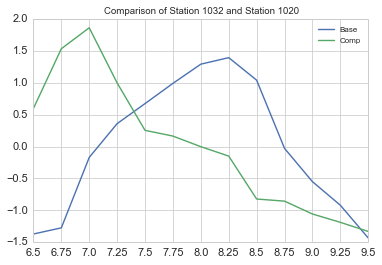

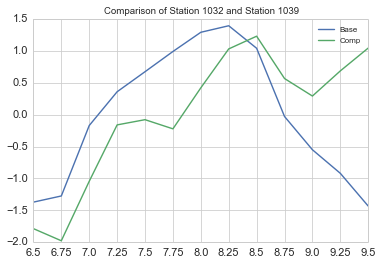

[0.95116975252367353,
 0.95293505672123568,
 0.9915079740813163,
 0.82840728302882916,
 0.92178624864830971,
 0.90853401681658774,
 0.010804071670300654,
 1.0000000000000002,
 0.92593852867355697,
 0.87162707562536079,
 0.79021897444483302,
 0.7288133227306659,
 0.69716803579121123,
 0.44428032027480213,
 0.94546853357508354,
 0.57327403279567879,
 0.81681864019031891,
 0.72255561193754048,
 0.63779721356776919,
 0.91998468921784748,
 0.92571307409331582,
 0.7313656476745295]

In [195]:
## Want to compare portions of time series across various stations. 

def compare_series(station_id,comparison_station=False,begin_time=4.5,end_time=9.5, print_plot=False):
    
    if(not comparison_station):
        comparison_station=[station_id]
    
    station_records=gate_count[gate_count['weekday']<5]
    station_records=station_records[(station_records['servicetime_frac']<=end_time) & (station_records['servicetime_frac']>=begin_time) ]
    
    #get subset of station 
    base_records=station_records[(station_records['locationid']==station_id)]
    base_grouping=base_records[['servicetime_frac','servicedate','entries']].groupby('servicetime_frac')
    base_entries=base_grouping.agg(np.mean)['entries']
    
    # Standardize the entries so we can indentify stations with similar behavior without worrying about scale
    base_entries_scaled=preprocessing.scale(base_entries)
    
    correlations=[]
    count=0
    
    for station in comparison_station:
        
        comp_records=station_records[(station_records['locationid']==station)]
        comp_grouping=comp_records[['servicetime_frac','servicedate','entries']].groupby('servicetime_frac')
        comp_entries=comp_grouping.agg(np.mean)['entries']
        
        comp_entries_scaled=preprocessing.scale(comp_entries)
        
        # np.correlate for two series of the same length returns a correlation which is <= length of the two series
        # since each pairwise comparison of the terms can yield an individual correlation of 1. Want to think of correlation
        # of series from [-1,1] so I divided by the length of the series
        correlations.append((np.correlate(base_entries_scaled,comp_entries_scaled)*1.0/len(base_entries_scaled))[0])
        
        # Print dissimilar stations
        if(print_plot& (correlations[count]<0.45)):
            plt.plot(base_entries_scaled,label='Base')
            plt.plot(comp_entries_scaled,label='Comp')
            plt.title('Comparison of Station '+str(station_id)+' and Station '+str(station))
            plt.legend()
            plt.xticks(range(13), list(comp_entries.index))
            plt.show()
        count+=1

        
        
    return correlations

compare_series(1032,comparison_station=red_stations_ids,begin_time=6.5,end_time=9.5,print_plot=True)

In [196]:
## Example: comparing Alewife and Forest Hills, both of which are terminal stations outside the city with bus connections
# running into them. Would expect similar behavior from the two. 

#sanity check: comparison for station 1032 should be 1.0 since it's the same as our base station
# station 1087: Forest Hills. 1077: State Street. 1052: Park.

all_correlations_1032=compare_series(1032,comparison_station=red_stations_ids,
                                     begin_time=5.,end_time=19.5)

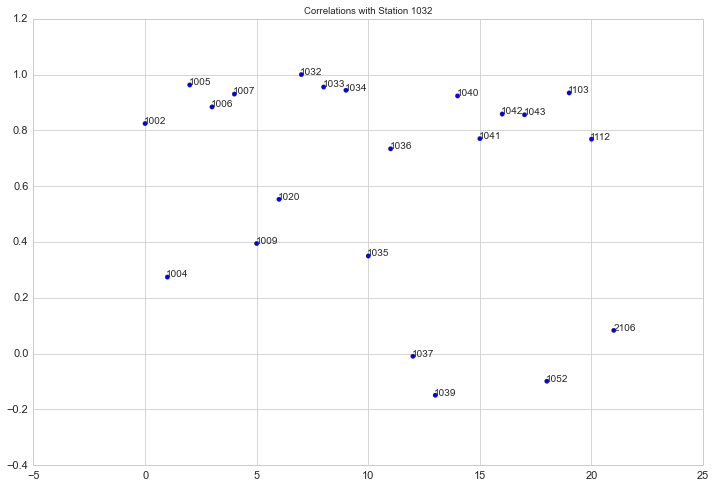

In [198]:
correlations_df=pd.DataFrame(zip(red_stations_ids,all_correlations_1032))
correlations_df=correlations_df.sort([0])

labels=list(correlations_df[0].values)
xs=range(len(correlations_df))
ys=list(correlations_df[1].values)

plt.figure(figsize=(12,8))
plt.scatter(xs,ys)
plt.title('Correlations with Station 1032')

for i, txt in enumerate(labels):
    plt.annotate(txt, (i,ys[i]))
    

In [199]:
'''fig, ax = plt.subplots()
heatmap = ax.pcolor(batter_df[cols],cmap=plt.get_cmap('seismic'),alpha=0.7)
fig = plt.gcf()'''
temp_ids=red_stations_ids

temp_ids.sort()

correlation_vectors=[]

for station in temp_ids:
    print station
    output=compare_series(station,comparison_station=temp_ids,begin_time=5.,end_time=19.5)
    
    correlations_df=pd.DataFrame(zip(temp_ids,output))
    #correlations_df=correlations_df.sort([0])

    correlation_vectors.append(list(correlations_df[1].values))
    

1002
1004
1005
1006
1007
1009
1020
1032
1033
1034
1035
1036
1037
1039
1040
1041
1042
1043
1052
1103
1112
2106


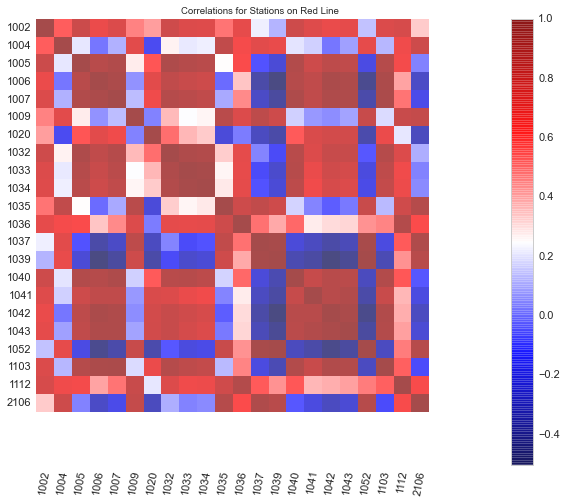

In [200]:

fig, ax = plt.subplots()
heatmap = ax.pcolor(pd.DataFrame(correlation_vectors),cmap=plt.get_cmap('seismic'),alpha=0.7)
fig = plt.gcf()
fig.set_size_inches(10,8)

ax.invert_yaxis()
ax.grid(False)
ax.set_frame_on(False)

ax.set_yticks(np.arange(len(temp_ids)) + 0.5, minor=False)
ax.set_xticks(np.arange(len(temp_ids))+0.5, minor=False) 

ax.set_xticklabels(temp_ids, minor=False)
ax.set_yticklabels(temp_ids, minor=False)

plt.xticks(rotation=80)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.title('Correlations for Stations on Red Line')
colorbar=plt.colorbar(heatmap)

plt.show()



##PCA and K-means Clustering

##Red Line Stations

###Idea:

Cluster the stations by taking their scaled mean entries at each time interval as a feature in our parameter space. Those stations with similar scaled mean entries will lie closer to one another in this higher dimensional space. Naturally, there will be some intervals which will contain more variation than the others. We can use PCA to reduce the dimensionality of our space and therefore get better measures of distance (or similarity) in the space. Once in the transformed space, run k-means or some other unsupervised clustering algorithm to group the stations. The idea is that we can perform the a priori clustering before the creation of the similarity matrix above, then order the rows so that similar rows are grouped together. Theoretically, this should bring those stations with greater correlation closer together and their pariwise comparisons closer to the diagonal in the matrix.

In [95]:
from sklearn.decomposition import PCA

In [232]:
map(get_name,red_stations_ids)

['Andrew Square',
 'JFK/U Mass',
 'North Quincy',
 'Wollaston',
 'Quincy Center',
 'South Station',
 'Braintree',
 'Alewife',
 'Davis Square',
 'Porter Square',
 'Harvard',
 'Central Square',
 'Kendall Square',
 'Downtown Crossing',
 'Savin Hill',
 'Fields Corner',
 'Shawmut',
 'Ashmont',
 'Park Street',
 'Quincy Adams',
 'Broadway',
 'Charles MGH']

In [229]:
# For each station
def get_scaled_entries(station_ids,begin_time=5,end_time=19.5):

    vector_entries_scaled=[]
    
    for station in station_ids:
        station_records=gate_count[gate_count['weekday']<5]
        station_records=station_records[(station_records['servicetime_frac']<=end_time) & (station_records['servicetime_frac']>=begin_time) ]

        #get subset of station 
        base_records=station_records[(station_records['locationid']==station)]
        base_grouping=base_records[['servicetime_frac','servicedate','entries']].groupby('servicetime_frac')
        base_entries=base_grouping.agg(np.mean)['entries']

        entries_scaled=preprocessing.scale(base_entries)
        
        vector_entries_scaled.append(list(entries_scaled))
        
    return vector_entries_scaled
    
    ## now for each station, have a vector of scaled entries over the window of interest.
    
c=get_scaled_entries(red_stations_ids)    
        

In [233]:
print "Number of stations: "+str(len(c))
print "Number of time intervals: "+str(len(c[0]))

pca = PCA(n_components=10)
pca.fit(c)

print "Number of PCA components: "+str(len(pca.components_))
print(pca.explained_variance_ratio_) 


Number of stations: 22
Number of time intervals: 59
Number of PCA components: 10
[ 0.77184484  0.12270871  0.04505357  0.02034875  0.00897912  0.00636945
  0.00566423  0.00404079  0.0030645   0.00198465]


In [235]:
pca = PCA(n_components=4)
pca.fit(c)

c_transformed=pca.transform(c)

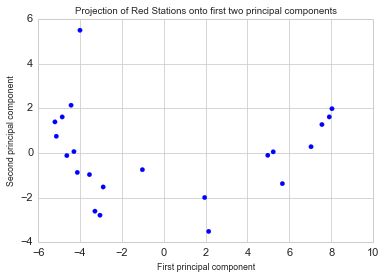

In [240]:
#Visualize the plot of first two principal components
components_transposed=c_transformed.transpose()

plt.scatter(components_transposed[0],components_transposed[1],color='blue',label='Stations')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of Red Stations onto first two principal components')
plt.show()

###Comments:
It seems that we can capture almost 90% of the variation using only 2 principal components. I will perform PCA with 4 components for now. Above is the plot of the first two components comprising of the majority of the variation. This is an unsupervised clustering task and I'm not sure how many groups to cluster the stations into. Based on the plot above, it seems that we can used k=3 clusters as a reasonable starting point. I'm not too concerned whether k=2,3, or 4 is the best choice because it's all in an effort to group similar stations closer together on the similarity matrix for easier representation. Thus, the visual differences between k=2,3,4 won't be too stark.

In [145]:
from sklearn import cluster

[[ 1.0248625  -2.08842791  0.38395536  1.16290114]
 [-4.12335389  0.21276236 -0.17255706 -0.19396108]
 [ 6.62937988  0.53030506  0.1312598  -0.16588149]]


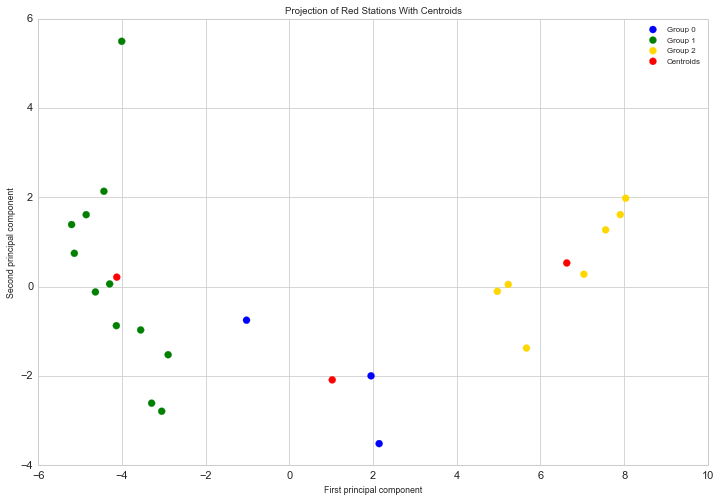

In [241]:
cluster_fn=cluster.KMeans(n_clusters=3)
cluster_fn.fit(c_transformed)

print cluster_fn.cluster_centers_

clusters=cluster_fn.cluster_centers_.transpose()
components_transposed=c_transformed.transpose()

#get the groupings
group0=cluster_fn.labels_==0
group1=cluster_fn.labels_==1
group2=cluster_fn.labels_==2

plt.figure(figsize=(12,8))
plt.scatter(components_transposed[0][group0],components_transposed[1][group0],s=50,color='blue',label='Group 0')
plt.scatter(components_transposed[0][group1],components_transposed[1][group1],s=50,color='green',label='Group 1')
plt.scatter(components_transposed[0][group2],components_transposed[1][group2],s=50,color='gold',label='Group 2') 
plt.scatter(clusters[0],clusters[1],color='red',label='Centroids',s=50)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of Red Stations With Centroids')
plt.legend()
plt.show()

###Comments:

The centroids look pretty reasonable. Going to continue with k=3 and see what the similarity matrix ends up looking like

In [279]:
group_0_ids=np.array(red_stations_ids)[group0]
print "First grouping: "+str(group_0_ids)
group_1_ids=np.array(red_stations_ids)[group1]
print "Second grouping: "+str(group_1_ids)
group_2_ids=np.array(red_stations_ids)[group2]
print "Third grouping: "+str(group_2_ids)

#reorder the IDS so that the similarity matrix has like-grouped ids near each other
reordered_ids=list(group_1_ids)+list(group_0_ids)+list(group_2_ids)
print "Re-ordered ID list: "+str(reordered_ids)


First grouping: [1002 1036 1112]
Second grouping: [1005 1006 1007 1020 1032 1033 1034 1040 1041 1042 1043 1103]
Third grouping: [1004 1009 1035 1037 1039 1052 2106]
Re-ordered ID list: [1005, 1006, 1007, 1020, 1032, 1033, 1034, 1040, 1041, 1042, 1043, 1103, 1002, 1036, 1112, 1004, 1009, 1035, 1037, 1039, 1052, 2106]


##New Similarity Matrix

Now let's build the similarity matrix, this time ordering the axes according to our reordered ID list

In [280]:
'''fig, ax = plt.subplots()
heatmap = ax.pcolor(batter_df[cols],cmap=plt.get_cmap('seismic'),alpha=0.7)
fig = plt.gcf()'''

temp_ids=reordered_ids

correlation_vectors=[]

for station in temp_ids:
    print station
    output=compare_series(station,comparison_station=temp_ids,begin_time=5.,end_time=19.5)
    
    correlations_df=pd.DataFrame(zip(temp_ids,output))

    correlation_vectors.append(list(correlations_df[1].values))    
    

1005
1006
1007
1020
1032
1033
1034
1040
1041
1042
1043
1103
1002
1036
1112
1004
1009
1035
1037
1039
1052
2106


In [281]:

def get_name(station_id):
    return(station_info[station_info['stationid']==station_id]['name'].values[0])


station_names=map(get_name,temp_ids)

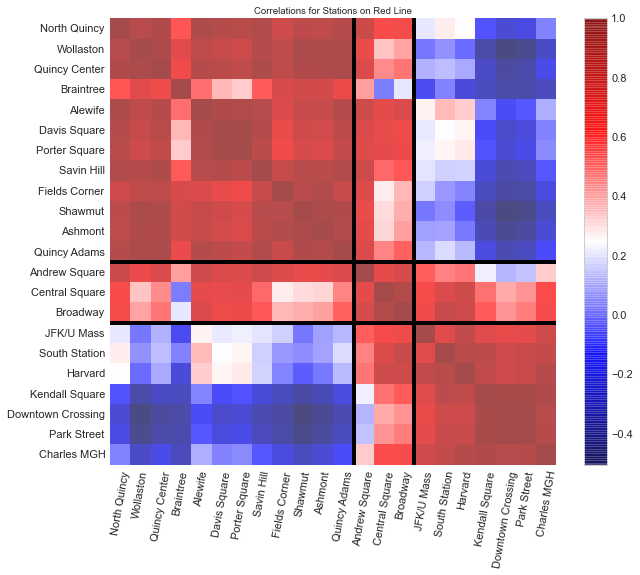

In [283]:

fig, ax = plt.subplots()
heatmap = ax.pcolor(pd.DataFrame(correlation_vectors),cmap=plt.get_cmap('seismic'),alpha=0.7)
fig = plt.gcf()
fig.set_size_inches(10,8)

# Clip the axes to remove white border
plt.ylim(0, len(temp_ids))
plt.xlim(0, len(temp_ids))

#invert so we orient the diagonal properly
ax.invert_yaxis()
ax.grid(False)
ax.set_frame_on(False)

# reorganize the ticks
ax.set_yticks(np.arange(len(temp_ids)) + 0.5, minor=False)
ax.set_xticks(np.arange(len(temp_ids))+0.5, minor=False) 
#put labels on the ticks
ax.set_xticklabels(station_names, minor=False)
ax.set_yticklabels(station_names, minor=False)

plt.xticks(rotation=80)
plt.rc('xtick', labelsize=11)
plt.rc('ytick', labelsize=11)
plt.title('Correlations for Stations on Red Line')
colorbar=plt.colorbar(heatmap)

# plot lines for the groups
plt.axhline(y=len(group_1_ids),xmin=0,xmax=(len(temp_ids)-15),color='black',linewidth=4)
plt.axhline(y=len(group_1_ids)+len(group_0_ids),xmin=0,xmax=(len(temp_ids)-15),color='black',linewidth=4)

plt.axvline(x=len(group_1_ids),ymin=0,ymax=(len(temp_ids)-15),color='black',linewidth=4)
plt.axvline(x=len(group_0_ids)+len(group_1_ids),ymin=0,ymax=(len(temp_ids)-15),color='black',linewidth=4)


plt.show()
